# TuLiP to Nubots Example: River Crossing

In [2]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from tulip import transys, spec, synth, dumpsmach
from fill_fts import *

# Binary vector to node name as string
def bv2str(bv):
  return ''.join('A' if b else 'B' for b in bv)

No handlers could be found for logger "polytope.solvers"


## Define finite transition system

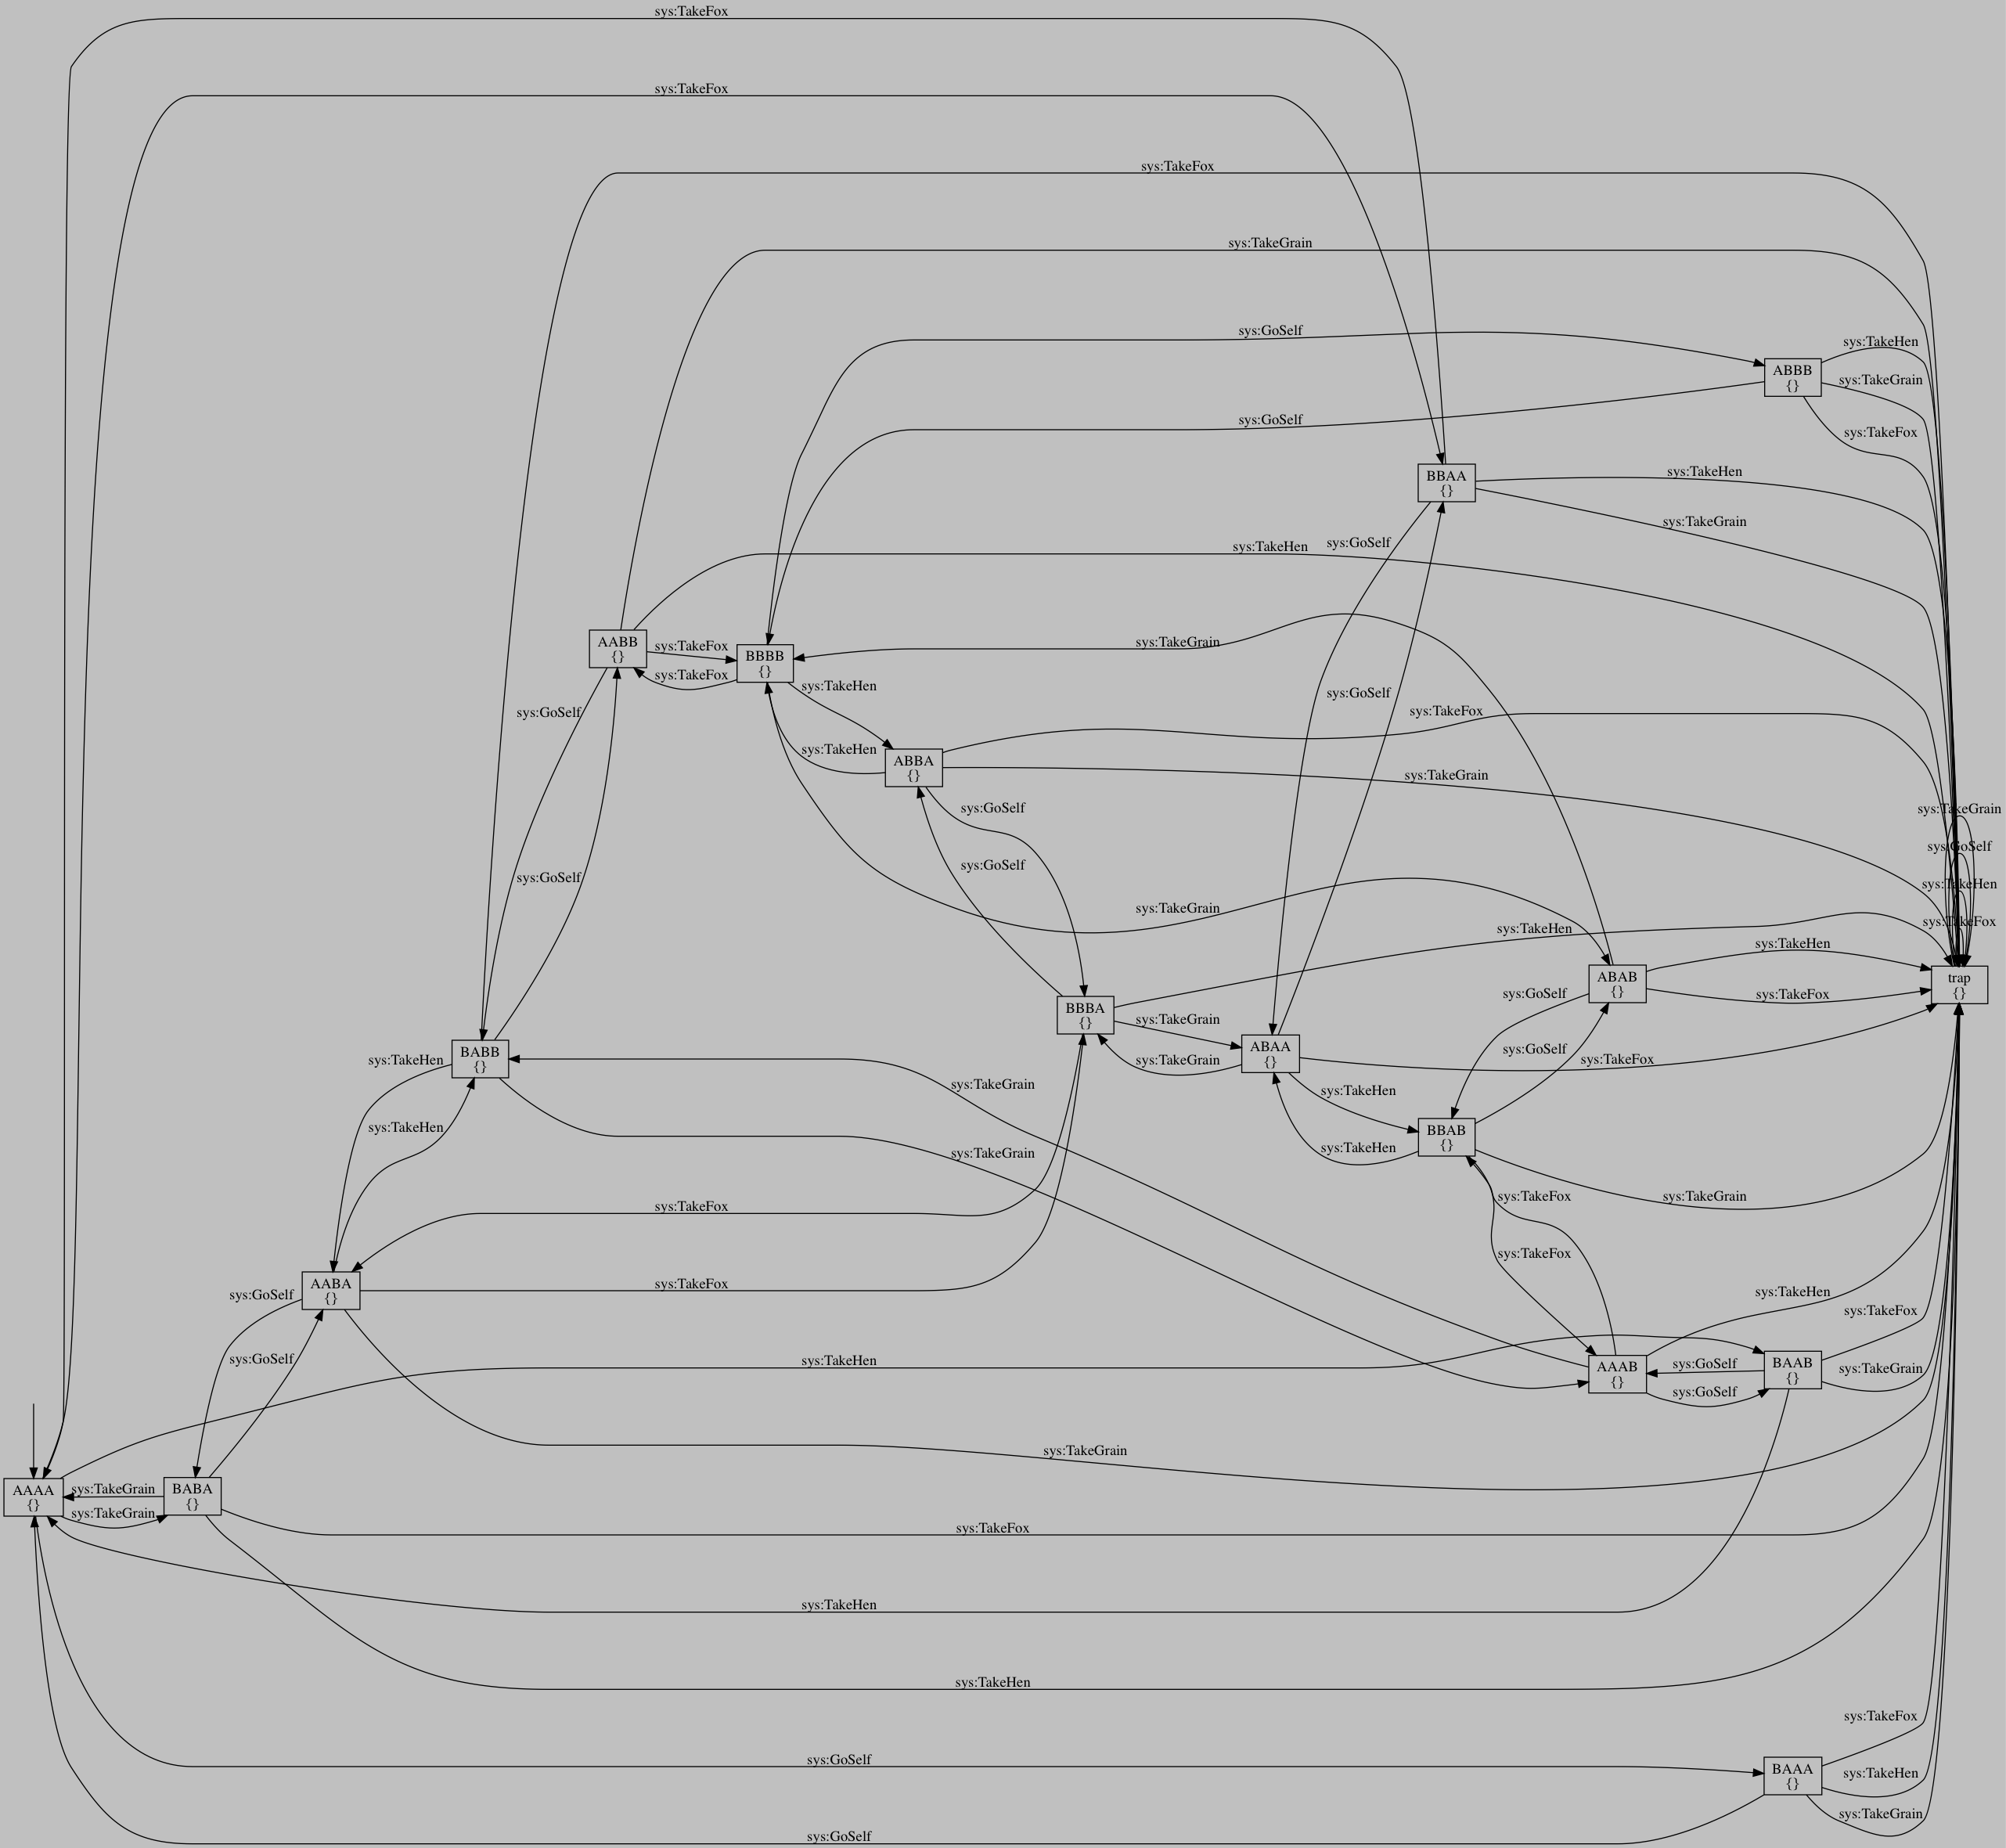

True

In [3]:
# State: [farmer fox chichen grain] \in {L,R}^4
fts = transys.FTS()

fts.sys_actions.add_from(['GoSelf', 'TakeFox', 'TakeHen', 'TakeGrain'])

# Add nodes
for bv in product([0,1], repeat=4):
    fts.add_node(bv2str(bv))

# Initial state
fts.states.initial.add('AAAA')

# Add transitions
for i in range(2):
    for j in range(2):
        fts.add_edge(bv2str([0,0,i,j]), bv2str([1,1,i,j]), sys_actions='TakeFox')
        fts.add_edge(bv2str([0,i,0,j]), bv2str([1,i,1,j]), sys_actions='TakeGrain')
        fts.add_edge(bv2str([0,i,j,0]), bv2str([1,i,j,1]), sys_actions='TakeHen')

        fts.add_edge(bv2str([1,1,i,j]), bv2str([0,0,i,j]), sys_actions='TakeFox')
        fts.add_edge(bv2str([1,i,1,j]), bv2str([0,i,0,j]), sys_actions='TakeGrain')
        fts.add_edge(bv2str([1,i,j,1]), bv2str([0,i,j,0]), sys_actions='TakeHen')
        
        for k in range(2):
            fts.add_edge(bv2str([0,i,j,k]), bv2str([1,i,j,k]), sys_actions='GoSelf')
            fts.add_edge(bv2str([1,i,j,k]), bv2str([0,i,j,k]), sys_actions='GoSelf')
            
# Add trap state and fill in actions
fill_fts(fts)

# Plot transition system
fts.plot()

## Define atomic propositions and specification

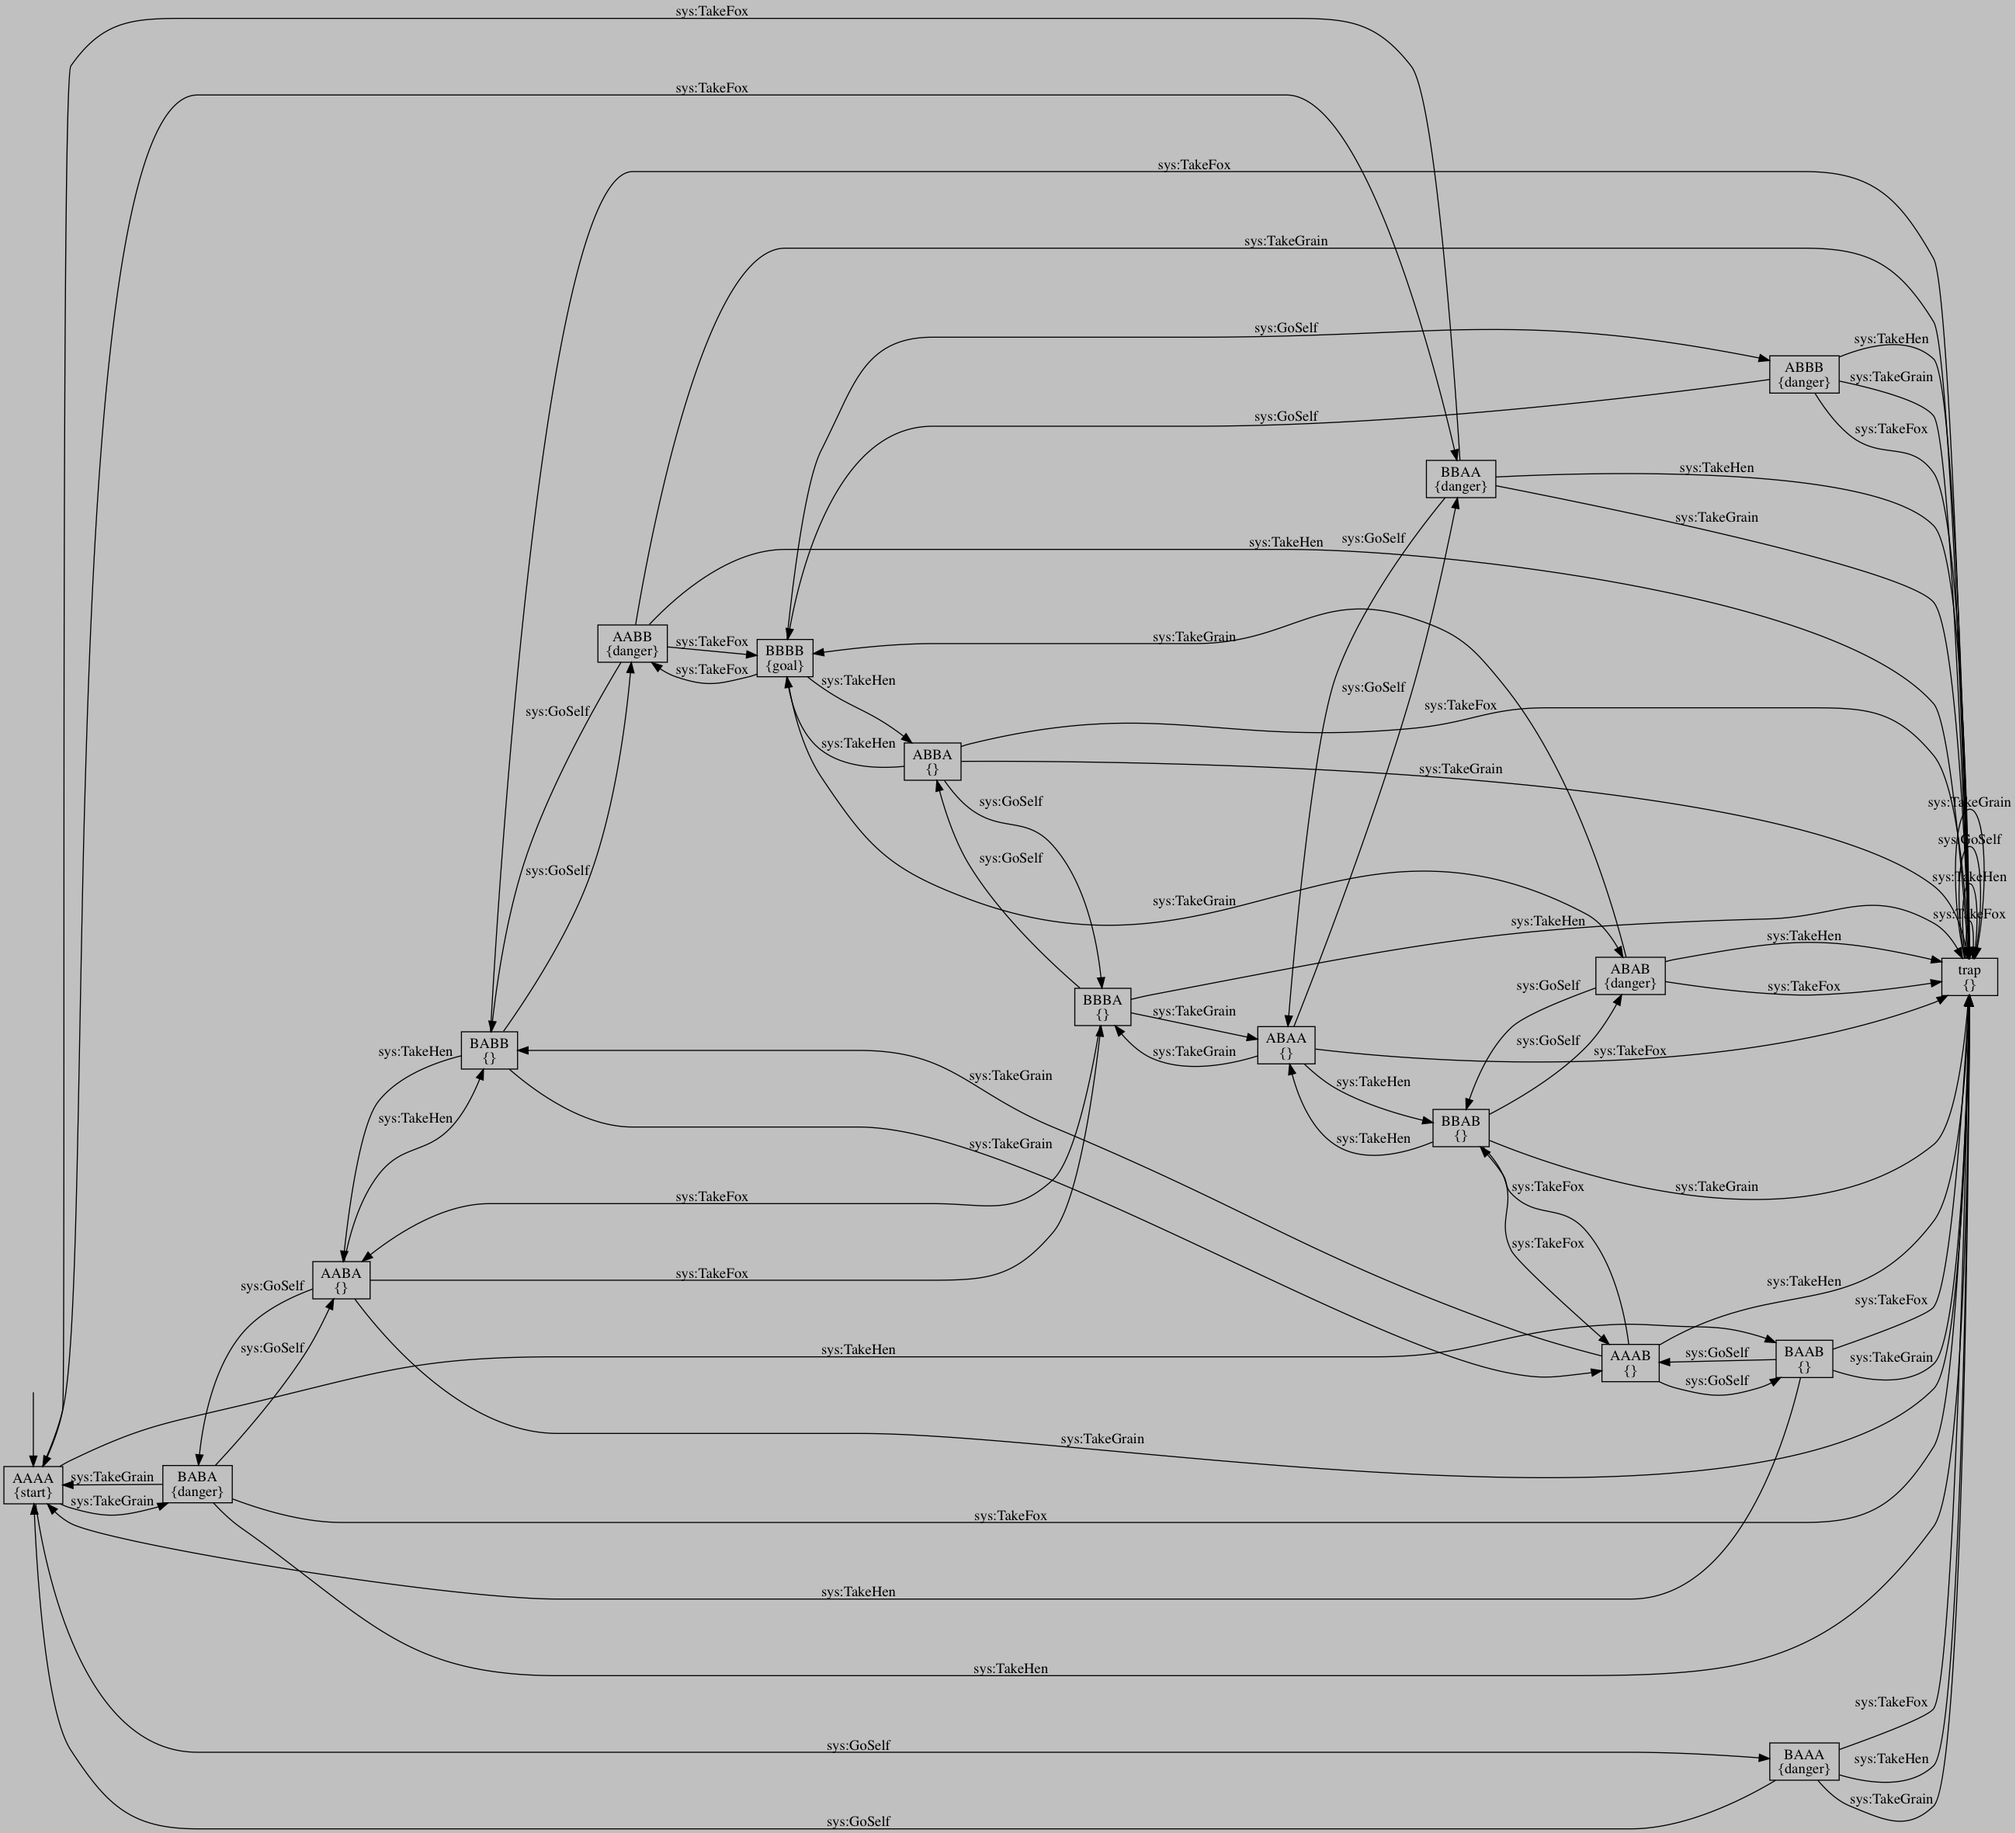

ENVIRONMENT VARIABLES:
	(none)

SYSTEM VARIABLES:
	(none)

FORMULA:
ASSUMPTION:
GUARANTEE:
    SAFETY
	  [](! danger)
    LIVENESS
	  []<>(goal)



In [6]:
# Add atomic propositions
fts.atomic_propositions.add_from({'start', 'goal', 'danger'})

fts.node['AAAA']['ap'].add('start')
fts.node['BBBB']['ap'].add('goal')

for state in product([0,1], repeat=4):
  if state[1] == state[3] and state[1] != state[0]:
    # fox and hen together, but no farmer
    fts.node[bv2str(state)]['ap'].add('danger')

  if state[2] == state[3] and state[2] != state[0]:
    # grain and hen together, but no farmer
    fts.node[bv2str(state)]['ap'].add('danger')

# Formula
env_vars = set()
env_init = set()
env_safe = set()
env_prog = set()
sys_vars = set()
sys_init = set()
sys_safe = {'! danger'}
sys_prog = {'goal'}
formula = spec.GRSpec(env_vars, sys_vars, env_init, sys_init,
                      env_safe, sys_safe, env_prog, sys_prog)

fts.plot()
print(formula.pretty())

## Solve synthesis problem

removed 0 nodes from 9 total


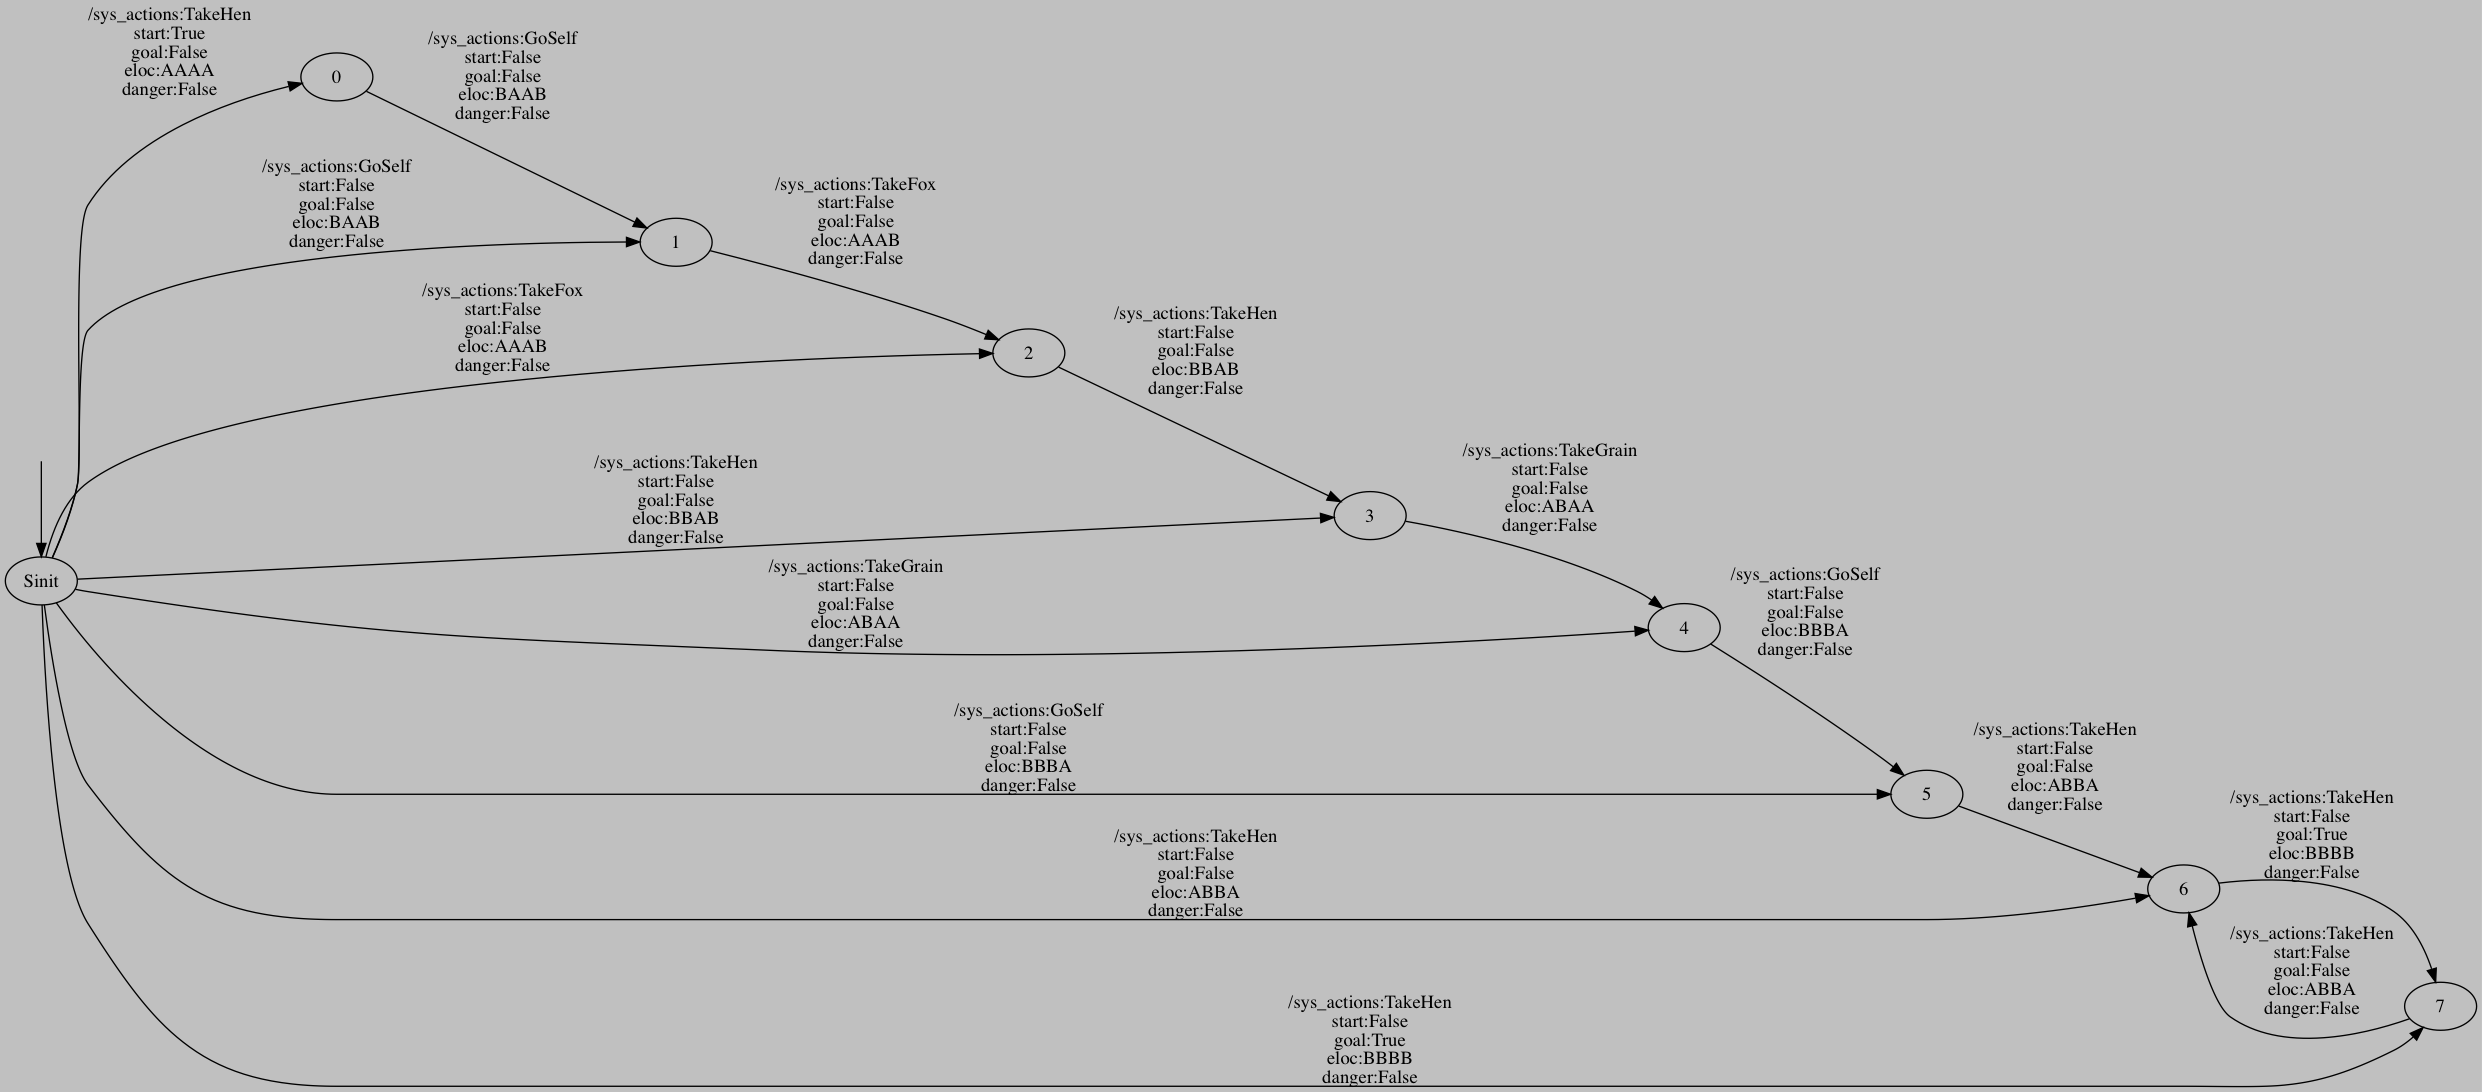

In [8]:
formula.moore = False
formula.plus_one = True
formula.qinit = '\A \E'
fts.owner = 'env'

ctrl = synth.synthesize('omega', formula, env=fts)

# Plot policy
ctrl.plot()

dumpsmach.write_python_case("river_policy.py", ctrl, classname="RiverPolicy")

In [9]:
ctrl.states()

[0, 1, 2, 3, 4, 5, 6, 7, 'Sinit']

## Simulation

In [65]:
from river_policy import RiverPolicy

loc = 'AAAA'

C = RiverPolicy()
for i in range(7):
    print "[{}]".format(loc)
    # APs at current loc
    start = 'start' in fts.node[loc]['ap']
    goal = 'goal' in fts.node[loc]['ap']
    danger = 'danger' in fts.node[loc]['ap']
    
    action = C.move(eloc=loc, start=start, goal=goal, danger=danger)['sys_actions']
    new_loc = [e[1] for e in fts.transitions.find(loc, with_attr_dict={'sys_actions':action})][0]
        
    # print "moved from {} to {} using {}".format(loc, new_loc, action)
    airport = {'fox': False, 'grain': False, 'hen': False}
    barn = {'fox': False, 'grain': False, 'hen': False}
    
    if (loc[1] == 'A'):
        airport['fox'] = True
    else:
        barn['fox'] = True
    
    if (loc[2] == 'A'):
        airport['grain'] = True
    else:
        barn['grain'] = True
        
    if (loc[3] == 'A'):
        airport['hen'] = True
    else:
        barn['hen'] = True
        
    airport_1 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '') + ('h' if airport['hen']==True else '')
    barn_1 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '') + ('h' if barn['hen']==True else '')
        
    
    if (loc[0] == 'A'): # farmer is at airport
        if (action=='TakeFox'):
            print "[TakeFox]"
            airport_2 = 'f\'' + ('g' if airport['grain']==True else '') + ('h' if airport['hen']==True else '')
            airport_3 = 'f\'\'' + ('g' if airport['grain']==True else '') + ('h' if airport['hen']==True else '')
            airport_4 = ('g' if airport['grain']==True else '') + ('h' if airport['hen']==True else '')
            print "hand airport.{} rigid (-1,0,0) hand.f' airport.{} rigid (-1,0,0) [farmer asks airport for fox]".format(airport_1, airport_2)
            print "airport.{} 🦊 rigid (-0.5,0.866,0) airport.{} 🦊 rigid (0.5,0.866,0) [airport offers fox to farmer]".format(airport_2, airport_2)
            print "hand.f' 🦊 null (-0.5,0.866,0) hand.f'' 🦊 rigid (-0.5,0.866,0) [farmer takes fox]"
            print "hand.f'' airport.{} rigid (-1,0,0) hand.f'' airport.{} rigid (-1,0,0) [tell airport that farmer has taken fox]".format(airport_2, airport_3)
            print "airport.{} 🦊 rigid (0.5,0.866,0) airport.{} 🦊 null (0.5,0.866,0) [airport let go of fox]".format(airport_3, airport_4)
            print "airport.{} hand.f'' rigid (1,0,0) airport.{}.nohand hand.f''.r null (1,0,0) [airport let go of hand]".format(airport_4,airport_4)
            print "hand.f''.r torso.pause flexible (-0.5,-0.866,0) hand.f''.r torso.r flexible (-0.5,-0.866,0) [hand tell torso to start walking right]".format(airport_4,airport_4)
            
            # Drop off fox
            barn_2 = 'f\'\'' + ('g' if barn['grain']==True else '') + ('h' if barn['hen']==True else '')
            barn_3 = 'f\'' + ('g' if barn['grain']==True else '') + ('h' if barn['hen']==True else '')
            barn_4 = 'f' + ('g' if barn['grain']==True else '') + ('h' if barn['hen']==True else '')
            
            print "torso.r barn.{}.nohand null (0.5,0.866,0) torso.pause barn.{}.nohand null (0.5,0.866,0) [pause movement]".format(barn_1, barn_1)
            print "torso.pause hand.f''.r flexible (-0.5,0.866,0) torso.pause hand.f'' flexible (-0.5,0.866,0) [torso tell hand it can bind to barn]"
            print "hand.f'' barn.{}.nohand null (1,0,0) hand.f'' barn.{} rigid (1,0,0) [hand bind to barn]".format(barn_1, barn_2)
            print "hand.f'' 🦊 rigid (-0.5,0.866,0) hand.f'' 🦊 rigid (0.5,0.866,0) [hand give fox to barn]"
            print "barn.{} 🦊 null (-0.5,0.866,0) barn.{} 🦊 rigid (-0.5,0.866,0) [barn take hold of fox]".format(barn_2,barn_3)
            print "barn.{} hand.f'' rigid (-1,0,0) barn.{} hand.f' rigid (-1,0,0) [tell farmer that barn has taken hen]".format(barn_3, barn_3)
            print "hand.f' 🦊 rigid (0.5,0.866,0) hand 🦊 null (0.5,0.866,0) [hand let go of hen]"
            print "barn.{} 🦊 rigid (-0.5,0.866,0) barn.{} 🦊 rigid (0.5,0.866,0) [barn put fox in place]".format(barn_3,barn_4)
        
        

        if (action=='TakeGrain'):
            print "[TakeGrain]"
            airport_2 = ('f' if airport['fox']==True else '') + 'g\'\'' + ('h' if airport['hen']==True else '')
            airport_3 = ('f' if airport['fox']==True else '') + 'g\'' + ('h' if airport['hen']==True else '')
            airport_4 = ('f' if airport['fox']==True else '') + ('h' if airport['hen']==True else '')
            print "hand airport.{} rigid (-1,0,0) hand.g' airport.{} rigid (-1,0,0) [farmer asks airport for grain]".format(airport_1, airport_2)
            print "airport.{} 🌾 rigid (-0.5,-0.433,0.7) airport.{} 🌾 rigid (0.5,0.866,0) [airport offers grain to farmer]".format(airport_2, airport_2)
            print "hand.g' 🌾 null (-0.5,0.866,0) hand.g'' 🌾 rigid (-0.5,0.866,0) [farmer takes grain]"
            print "hand.g'' airport.{} rigid (-1,0,0) hand.g'' airport.{} rigid (-1,0,0) [tell airport that farmer has taken grain]".format(airport_2, airport_3)
            print "airport.{} 🌾 rigid (0.5,0.866,0) airport.{} 🌾 null (0.5,0.866,0) [airport let go of grain]".format(airport_3, airport_4)
            print "airport.{} hand.g'' rigid (1,0,0) airport.{}.nohand hand.g''.r null (1,0,0) [airport let go of hand]".format(airport_4,airport_4)
            print "hand.g''.r torso.pause flexible (-0.5,-0.866,0) hand.g''.r torso.r flexible (-0.5,-0.866,0) [hand tell torso to start walking right]".format(airport_4,airport_4)
    
            # Drop off grain
            barn_2 = ('f' if barn['fox']==True else '') + 'g\'\'' + ('h' if barn['hen']==True else '')
            barn_3 = ('f' if barn['fox']==True else '') + 'g\'' + ('h' if barn['hen']==True else '')
            barn_4 = ('f' if barn['fox']==True else '') + 'g' + ('h' if barn['hen']==True else '')
            
        
            print "torso.r barn.{}.nohand null (0.5,0.866,0) torso.pause barn.{}.nohand null (0.5,0.866,0) [pause movement]".format(barn_1, barn_1)
            print "torso.pause hand.g''.r flexible (-0.5,0.866,0) torso.pause hand.g'' flexible (-0.5,0.866,0) [torso tell hand it can bind to barn]"
            print "hand.g'' barn.{}.nohand null (1,0,0) hand.g'' barn.{} rigid (1,0,0) [hand bind to barn]".format(barn_1, barn_2)
            print "hand.g'' 🌾 rigid (-0.5,0.866,0) hand.g'' 🌾 rigid (0.5,0.866,0) [hand give grain to barn]"
            print "barn.{} 🌾 null (-0.5,0.866,0) barn.{} 🌾 rigid (-0.5,0.866,0) [barn take hold of grain]".format(barn_2,barn_3)
            print "barn.{} hand.g'' rigid (-1,0,0) barn.{} hand.g' rigid (-1,0,0) [tell farmer that barn has taken grain]".format(barn_3, barn_3)
            print "hand.g' 🌾 rigid (0.5,0.866,0) hand 🌾 null (0.5,0.866,0) [hand let go of grain]"
            print "barn.{} 🌾 rigid (-0.5,0.866,0) barn.{} 🌾 rigid (0.5,-0.433,0.7) [barn put grain in place]".format(barn_3,barn_4)
        
            
        if (action=='TakeHen'):
            print "[TakeHen]"
            airport_2 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '') + 'h\''
            airport_3 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '') + 'h\'\''
            airport_4 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '')
            print "hand airport.{} rigid (-1,0,0) hand.h' airport.{} rigid (-1,0,0) [farmer asks airport for hen]".format(airport_1, airport_2)
            print "airport.{} 🐔 rigid (-0.5,-0.433,-0.7) airport.{} 🐔 rigid (0.5,0.866,0) [airport offers hen to farmer]".format(airport_2, airport_2)
            print "hand.h' 🐔 null (-0.5,0.866,0) hand.h'' 🐔 rigid (-0.5,0.866,0) [farmer takes hen]"
            print "hand.h'' airport.{} rigid (-1,0,0) hand.h'' airport.{} rigid (-1,0,0) [tell airport that farmer has taken fox]".format(airport_2, airport_3)
            print "airport.{} 🐔 rigid (0.5,0.866,0) airport.{} 🐔 null (0.5,0.866,0) [airport let go of fox]".format(airport_3, airport_4)
            print "airport.{} hand.h'' rigid (1,0,0) airport.{}.nohand hand.h''.r null (1,0,0) [airport let go of hand]".format(airport_4,airport_4)
            print "hand.h''.r torso.pause flexible (-0.5,-0.866,0) hand.h''.r torso.r flexible (-0.5,-0.866,0) [hand tell torso to start walking right]".format(airport_4,airport_4)
    
            # Drop off hen
            barn_2 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '') + 'h\'\''
            barn_3 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '') + 'h\''
            barn_4 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '') + 'h'
            
        
            print "torso.r barn.{}.nohand null (0.5,0.866,0) torso.pause barn.{}.nohand null (0.5,0.866,0) [pause movement]".format(barn_1, barn_1)
            print "torso.pause hand.h''.r flexible (-0.5,0.866,0) torso.pause hand.h'' flexible (-0.5,0.866,0) [torso tell hand it can bind to barn]"
            print "hand.h'' barn.{}.nohand null (1,0,0) hand.h'' barn.{} rigid (1,0,0) [hand bind to barn]".format(barn_1, barn_2)
            print "hand.h'' 🐔 rigid (-0.5,0.866,0) hand.h'' 🐔 rigid (0.5,0.866,0) [hand give hen to barn]"
            print "barn.{} 🐔 null (-0.5,0.866,0) barn.{} 🐔 rigid (-0.5,0.866,0) [barn take hold of hen]".format(barn_2,barn_3)
            print "barn.{} hand.h'' rigid (-1,0,0) barn.{} hand.h' rigid (-1,0,0) [tell farmer that barn has taken hen]".format(barn_3, barn_3)
            print "hand.h' 🐔 rigid (0.5,0.866,0) hand 🐔 null (0.5,0.866,0) [hand let go of hen]"
            print "barn.{} 🐔 rigid (-0.5,0.866,0) barn.{} 🐔 rigid (0.5,-0.433,-0.7) [barn put hen in place]".format(barn_3,barn_4)
        
        
        if (action=='GoSelf'):
            pass
    
    else: # farmer is at barn
        if (action=='TakeFox'):
            pass
            

        if (action=='TakeGrain'):
            pass
            
        if (action=='TakeHen'):
            print "[TakeHen]"
            barn_2 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '') + 'h\''
            barn_3 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '') + 'h\'\''
            barn_4 = ('f' if barn['fox']==True else '') + ('g' if barn['grain']==True else '')
            print "hand barn.{} rigid (1,0,0) hand.h' barn.{} rigid (1,0,0) [farmer asks barn for hen]".format(barn_1, barn_2)
            print "barn.{} 🐔 rigid (0.5,-0.433,-0.7) barn.{} 🐔 rigid (-0.5,0.866,0) [barn offers hen to farmer]".format(barn_2, barn_2)
            print "hand.h' 🐔 null (0.5,0.866,0) hand.h'' 🐔 rigid (0.5,0.866,0) [farmer takes hen]"
            print "hand.h'' barn.{} rigid (1,0,0) hand.h'' barn.{} rigid (1,0,0) [tell barn that farmer has taken hen]".format(barn_2, barn_3)
            print "barn.{} 🐔 rigid (-0.5,0.866,0) barn.{} 🐔 null (-0.5,0.866,0) [barn let go of hen]".format(barn_3, barn_4)
            print "barn.{} hand.h'' rigid (-1,0,0) barn.{}.nohand hand.h''.l null (-1,0,0) [barn let go of hand]".format(barn_4,barn_4)
            print "hand.h''.l torso.pause flexible (0.5,-0.866,0) hand.h''.l torso.l flexible (0.5,-0.866,0) [hand tell torso to start walking left]".format(barn_4,barn_4)
    
            # Drop off hen
            airport_2 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '') + 'h\'\''
            airport_3 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '') + 'h\''
            airport_4 = ('f' if airport['fox']==True else '') + ('g' if airport['grain']==True else '') + 'h'
            
        
            print "torso.l airport.{}.nohand null (-0.5,0.866,0) torso.pause airport.{}.nohand null (-0.5,0.866,0) [pause movement]".format(airport_1, airport_1)
            print "torso.pause hand.h''.l flexible (0.5,0.866,0) torso.pause hand.h'' flexible (0.5,0.866,0) [torso tell hand it can bind to airport]"
            print "hand.h'' airport.{}.nohand null (-1,0,0) hand.h'' airport.{} rigid (-1,0,0) [hand bind to airport]".format(airport_1, airport_2)
            print "hand.h'' 🐔 rigid (0.5,0.866,0) hand.h'' 🐔 rigid (-0.5,0.866,0) [hand give hen to airport]"
            print "airport.{} 🐔 null (0.5,0.866,0) airport.{} 🐔 rigid (0.5,0.866,0) [airport take hold of hen]".format(airport_2,airport_3)
            print "airport.{} hand.h'' rigid (1,0,0) airport.{} hand.h' rigid (1,0,0) [tell farmer that airport has taken hen]".format(airport_3, airport_3)
            print "hand.h' 🐔 rigid (-0.5,0.866,0) hand 🐔 null (-0.5,0.866,0) [hand let go of hen]"
            print "airport.{} 🐔 rigid (0.5,0.866,0) airport.{} 🐔 rigid (-0.5,-0.433,-0.7) [airport put hen in place]".format(airport_3,airport_4)
        
        
        if (action=='GoSelf'):
            print "[GoSelf]"
            print "barn.{} hand rigid (-1,0,0) barn.{}.nohand hand..l null (-1,0,0) [barn let go of hand]".format(barn_1, barn_1)
            print "torso.l airport.{}.nohand null (-0.5,0.866,0) torso.pause airport.{}.nohand null (-0.5,0.866,0) [pause movement]".format(airport_1, airport_1)
            print "hand..l torso.pause flexible (0.5,-0.866,0) hand..l torso.l flexible (0.5,-0.866,0) [hand tell torso to move left]"
            print "torso.pause hand..l flexible (0.5,0.866,0) torso.pause hand flexible (0.5,0.866,0) [torso tell hand it can bind to barn]"
            print "hand airport.{}.nohand null (-1,0,0) hand airport.{} rigid (-1,0,0) [hand bind to airport]".format(airport_1, airport_1)
        
        

    
    
    loc = new_loc
    
print "\n\
[Move right]\n\
torso.r foot rigid (-0.5,-0.866,0) torso.r foot rigid (0.5,-0.866,0)\n\
foot torso.r rigid (-0.5,0.866,0) foot torso.r rigid (0.5,0.866,0)\n\
\n\
[Move left]\n\
torso.l foot rigid (0.5,-0.866,0) torso.l foot rigid (-0.5,-0.866,0)\n\
foot torso.l rigid (0.5,0.866,0) foot torso.l rigid (-0.5,0.866,0)\n\
"
print "\n\
[Eating]\n\
airport.fh.nohand 🐔 rigid (-0.5,-0.433,-0.7) ⚠ 💀 rigid (-0.5,-0.433,-0.7)\n\
airport.fgh.nohand 🐔 rigid (-0.5,-0.433,-0.7) ⚠ 💀 rigid (-0.5,-0.433,-0.7)\n\
barn.fh.nohand 🐔 rigid (0.5,-0.433,-0.7) ⚠ 💀 rigid (0.5,-0.433,-0.7)\n\
barn.fgh.nohand 🐔 rigid (0.5,-0.433,-0.7) ⚠ 💀 rigid (0.5,-0.433,-0.7)\n\
airport.gh.nohand 🌾 rigid (-0.5,-0.433,0.7) ⚠ 💀 rigid (-0.5,-0.433,0.7)\n\
airport.fgh.nohand 🌾 rigid (-0.5,-0.433,0.7) ⚠ 💀 rigid (-0.5,-0.433,0.7)\n\
barn.gh.nohand 🌾 rigid (0.5,-0.433,0.7) ⚠ 💀 rigid (0.5,-0.433,0.7)\n\
barn.fgh.nohand 🌾 rigid (0.5,-0.433,0.7) ⚠ 💀 rigid (0.5,-0.433,0.7)\n\
"

[AAAA]
[TakeHen]
hand airport.fgh rigid (-1,0,0) hand.h' airport.fgh' rigid (-1,0,0) [farmer asks airport for hen]
airport.fgh' 🐔 rigid (-0.5,-0.433,-0.7) airport.fgh' 🐔 rigid (0.5,0.866,0) [airport offers hen to farmer]
hand.h' 🐔 null (-0.5,0.866,0) hand.h'' 🐔 rigid (-0.5,0.866,0) [farmer takes hen]
hand.h'' airport.fgh' rigid (-1,0,0) hand.h'' airport.fgh'' rigid (-1,0,0) [tell airport that farmer has taken fox]
airport.fgh'' 🐔 rigid (0.5,0.866,0) airport.fg 🐔 null (0.5,0.866,0) [airport let go of fox]
airport.fg hand.h'' rigid (1,0,0) airport.fg.nohand hand.h''.r null (1,0,0) [airport let go of hand]
hand.h''.r torso.pause flexible (-0.5,-0.866,0) hand.h''.r torso.r flexible (-0.5,-0.866,0) [hand tell torso to start walking right]
torso.r barn..nohand null (0.5,0.866,0) torso.pause barn..nohand null (0.5,0.866,0) [pause movement]
torso.pause hand.h''.r flexible (-0.5,0.866,0) torso.pause hand.h'' flexible (-0.5,0.866,0) [torso tell hand it can bind to barn]
hand.h'' barn..nohand nul